# Small Cardamom Price Forecasting — Enriched Model

This notebook builds a time-series forecasting model enriched with **external data** to predict the **Average Price (Rs./Kg)** of small cardamom.

### External Data Sources
| Source | Signal | Granularity |
|--------|--------|-------------|
| Open-Meteo | Idukki rainfall, temperature, humidity | Daily |
| Open-Meteo | Guatemala (Alta Verapaz) rainfall & temp | Daily |
| NOAA | El Niño/La Niña (ONI index) | Monthly (3-month rolling) |
| Yahoo Finance | USD/INR exchange rate | Daily |
| Yahoo Finance | Brent Crude Oil prices | Daily |
| Yahoo Finance | Nifty 50 index | Daily |
| Yahoo Finance | Gold prices (USD) | Daily |
| Custom | Indian festival/wedding/harvest calendar | Daily |

## 1. Load All Data Sources

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['figure.dpi'] = 100

# --- Cardamom auction data ---
df = pd.read_html('Small Cardamom Auction Prices.xls', header=0)[0]
df = df[df.iloc[:, 0] != 'Date of Auction'].reset_index(drop=True)
df.columns = ['Date', 'Auctioneer', 'Lots', 'Qty_Arrived_Kg', 'Qty_Sold_Kg', 'MaxPrice', 'AvgPrice']
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=False)
for col in ['Lots', 'Qty_Arrived_Kg', 'Qty_Sold_Kg', 'MaxPrice', 'AvgPrice']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=['Date']).reset_index(drop=True)

# Aggregate to daily
daily = df.groupby('Date').agg(
    Total_Lots=('Lots', 'sum'),
    Total_Arrived=('Qty_Arrived_Kg', 'sum'),
    Total_Sold=('Qty_Sold_Kg', 'sum'),
    MaxPrice=('MaxPrice', 'max'),
    AvgPrice=('AvgPrice', lambda x: np.average(x, weights=df.loc[x.index, 'Qty_Sold_Kg'].clip(lower=1))),
    Num_Auctions=('Auctioneer', 'nunique')
).reset_index()
daily = daily.sort_values('Date').reset_index(drop=True)
daily = daily[daily['AvgPrice'] > 0].reset_index(drop=True)
print(f'Cardamom: {len(daily)} daily records ({daily["Date"].min().date()} to {daily["Date"].max().date()})')

Cardamom: 3028 daily records (2014-11-07 to 2026-02-06)


In [2]:
# --- Load external data ---

# Idukki weather
weather = pd.read_csv('external_idukki_weather.csv', parse_dates=['Date'])
print(f'Idukki weather: {len(weather)} rows')

# Guatemala weather
gt_weather = pd.read_csv('external_guatemala_weather.csv', parse_dates=['Date'])
print(f'Guatemala weather: {len(gt_weather)} rows')

# USD/INR — yfinance CSV has 3 header rows: Price, Ticker, Date
def load_yfinance_csv(path, value_col_name):
    """Load yfinance multi-header CSV, extract Date and Close columns."""
    raw = pd.read_csv(path, header=None, skiprows=3)
    raw.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
    raw['Date'] = pd.to_datetime(raw['Date'])
    raw = raw[['Date', 'Close']].rename(columns={'Close': value_col_name})
    raw[value_col_name] = pd.to_numeric(raw[value_col_name], errors='coerce')
    return raw.dropna()

usdinr = load_yfinance_csv('external_usdinr.csv', 'USDINR')
print(f'USD/INR: {len(usdinr)} rows')

oil = load_yfinance_csv('external_crude_oil.csv', 'CrudeOil_USD')
print(f'Crude Oil: {len(oil)} rows')

gold = load_yfinance_csv('external_gold.csv', 'Gold_USD')
print(f'Gold: {len(gold)} rows')

nifty = load_yfinance_csv('external_nifty50.csv', 'Nifty50')
print(f'Nifty 50: {len(nifty)} rows')

# Festival calendar
festivals = pd.read_csv('external_festival_calendar.csv', parse_dates=['Date'])
print(f'Festival calendar: {len(festivals)} rows')

# ENSO ONI index
oni_raw = pd.read_csv('external_enso_oni.csv')
season_to_month = {
    'DJF': 1, 'JFM': 2, 'FMA': 3, 'MAM': 4, 'AMJ': 5, 'MJJ': 6,
    'JJA': 7, 'JAS': 8, 'ASO': 9, 'SON': 10, 'OND': 11, 'NDJ': 12
}
oni_raw['month'] = oni_raw['SEAS'].map(season_to_month)
oni_raw['Date'] = pd.to_datetime(oni_raw['YR'].astype(str) + '-' + oni_raw['month'].astype(str) + '-15')
oni = oni_raw[['Date', 'ANOM']].rename(columns={'ANOM': 'ENSO_ONI'})
oni = oni.set_index('Date').resample('D').ffill().reset_index()
print(f'ENSO ONI: {len(oni)} rows (daily, forward-filled)')

Idukki weather: 4420 rows
Guatemala weather: 4420 rows
USD/INR: 2932 rows
Crude Oil: 2833 rows
Gold: 2831 rows
Nifty 50: 2773 rows
Festival calendar: 4748 rows
ENSO ONI: 27729 rows (daily, forward-filled)


## 2. Merge All Data

In [3]:
# Merge everything onto the daily cardamom price dataframe
merged = daily.copy()

# Merge weather (exact date match)
merged = merged.merge(weather, on='Date', how='left')
merged = merged.merge(gt_weather, on='Date', how='left')

# Merge financial data (forward-fill for non-trading days)
for ext_df, name in [(usdinr, 'USDINR'), (oil, 'CrudeOil_USD'), (gold, 'Gold_USD'), (nifty, 'Nifty50')]:
    ext_df = ext_df.sort_values('Date').drop_duplicates(subset='Date')
    merged = merged.merge(ext_df, on='Date', how='left')
    merged[name] = merged[name].ffill()

# Merge festival calendar
merged = merged.merge(festivals, on='Date', how='left')
festival_cols = ['wedding_season', 'harvest_season', 'peak_harvest', 'pre_eid_period', 
                 'pre_diwali_period', 'pre_onam_period', 'xmas_newyear']
for col in festival_cols:
    merged[col] = merged[col].fillna(0).astype(int)

# Merge ENSO
merged = merged.merge(oni, on='Date', how='left')
merged['ENSO_ONI'] = merged['ENSO_ONI'].ffill()

# Check coverage
print(f'Merged dataset: {merged.shape}')
print(f'\nMissing values:')
missing = merged.isnull().sum()
print(missing[missing > 0])

# Forward-fill remaining gaps, then drop any remaining
merged = merged.ffill().bfill()
merged = merged.dropna().reset_index(drop=True)
print(f'\nFinal merged: {len(merged)} rows')
merged.head()

Merged dataset: (3028, 28)

Missing values:
Series([], dtype: int64)

Final merged: 3028 rows


,Date,Total_Lots,Total_Arrived,Total_Sold,MaxPrice,AvgPrice,Num_Auctions,precipitation_mm,rain_mm,temp_max_c,...,Gold_USD,Nifty50,wedding_season,harvest_season,peak_harvest,pre_eid_period,pre_diwali_period,pre_onam_period,xmas_newyear,ENSO_ONI
0,2014-11-07,477,109975.0,109076.0,958.0,765.730000,1,0.9,0.9,27.2,...,1169.599976,8337.000000,1,1,1,0,0,0,0,0.54
1,2015-01-14,350,76699.0,76699.0,1130.0,861.930000,1,0.1,0.1,26.2,...,1234.400024,8277.549805,1,1,0,0,0,0,0,0.77
2,2015-05-01,203,31117.0,30755.0,928.0,706.624575,2,5.8,5.8,29.0,...,1174.500000,8277.549805,1,0,0,0,0,0,0,0.81
3,2015-05-02,488,82457.0,75138.0,990.0,681.104290,2,4.3,4.3,28.2,...,1174.500000,8277.549805,1,0,0,0,0,0,0,0.81
4,2015-05-04,242,39221.0,38109.0,964.0,673.615962,2,13.5,13.5,28.4,...,1186.800049,8331.950195,1,0,0,0,0,0,0,0.81


## 3. Exploratory Analysis of External Features

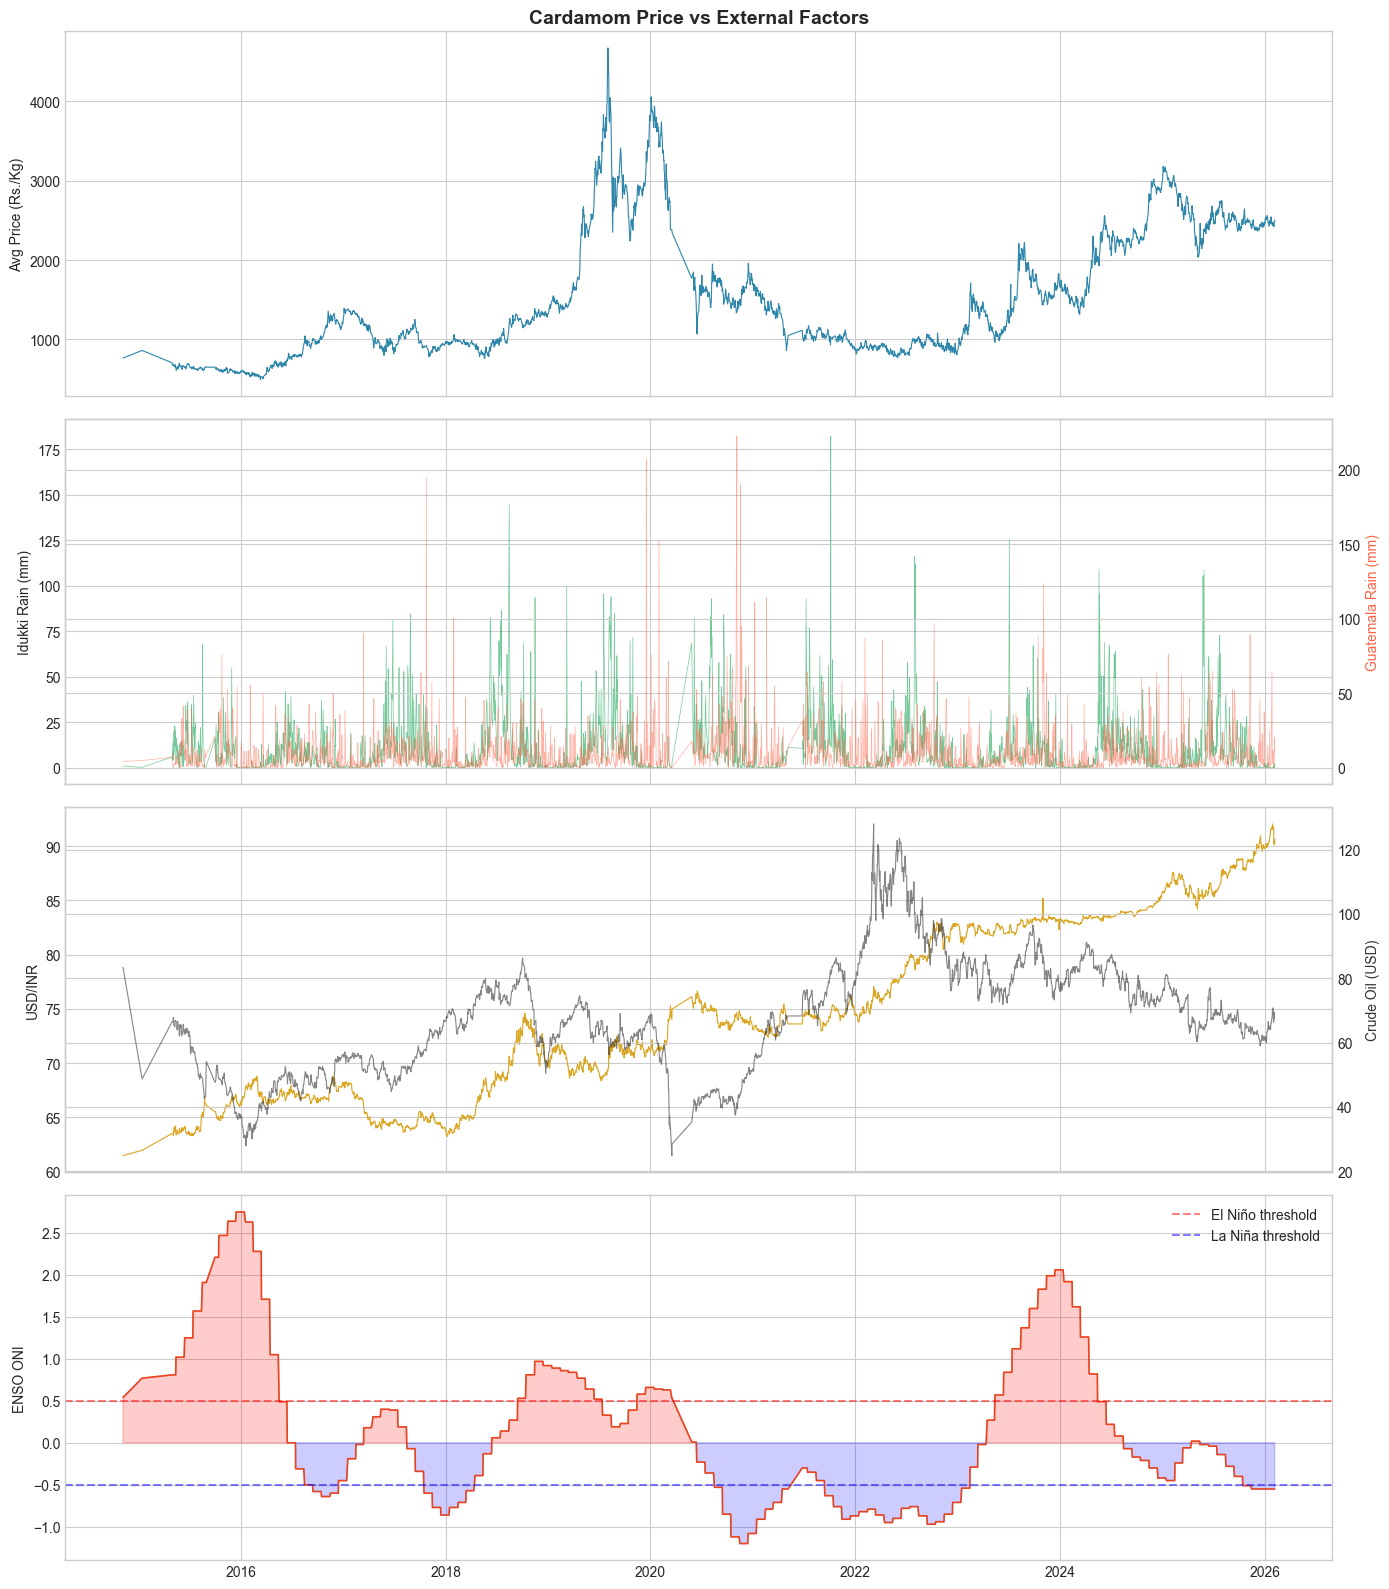

In [4]:
# Visualize key external features alongside cardamom price
fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

axes[0].plot(merged['Date'], merged['AvgPrice'], color='#2E86AB', linewidth=0.8)
axes[0].set_ylabel('Avg Price (Rs./Kg)')
axes[0].set_title('Cardamom Price vs External Factors', fontsize=14, fontweight='bold')

axes[1].plot(merged['Date'], merged['rain_mm'], color='#3CB371', linewidth=0.5, alpha=0.7)
axes[1].set_ylabel('Idukki Rain (mm)')
ax1b = axes[1].twinx()
ax1b.plot(merged['Date'], merged['gt_rain_mm'], color='#FF6347', linewidth=0.5, alpha=0.5)
ax1b.set_ylabel('Guatemala Rain (mm)', color='#FF6347')

axes[2].plot(merged['Date'], merged['USDINR'], color='#DAA520', linewidth=0.8)
axes[2].set_ylabel('USD/INR')
ax2b = axes[2].twinx()
ax2b.plot(merged['Date'], merged['CrudeOil_USD'], color='#333333', linewidth=0.8, alpha=0.6)
ax2b.set_ylabel('Crude Oil (USD)', color='#333')

axes[3].plot(merged['Date'], merged['ENSO_ONI'], color='#E8451E', linewidth=1.2)
axes[3].axhline(0.5, color='red', linestyle='--', alpha=0.5, label='El Niño threshold')
axes[3].axhline(-0.5, color='blue', linestyle='--', alpha=0.5, label='La Niña threshold')
axes[3].fill_between(merged['Date'], merged['ENSO_ONI'], 0, 
                     where=merged['ENSO_ONI'] > 0, alpha=0.2, color='red')
axes[3].fill_between(merged['Date'], merged['ENSO_ONI'], 0, 
                     where=merged['ENSO_ONI'] < 0, alpha=0.2, color='blue')
axes[3].set_ylabel('ENSO ONI')
axes[3].legend()

plt.tight_layout()
plt.show()

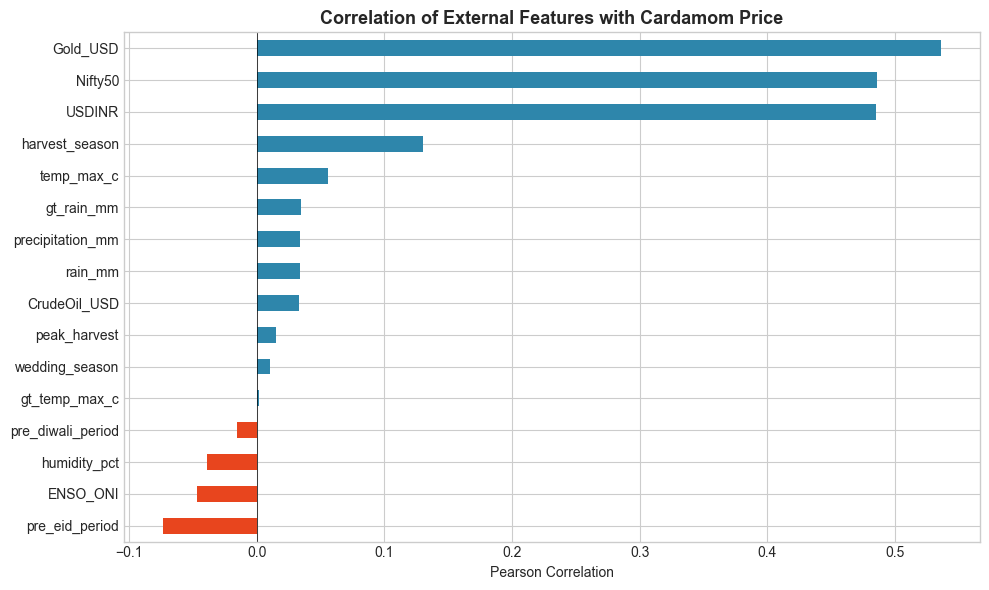

In [5]:
# Correlation of external features with cardamom price
ext_corr_cols = ['AvgPrice', 'rain_mm', 'precipitation_mm', 'temp_max_c', 'humidity_pct',
                 'gt_rain_mm', 'gt_temp_max_c', 'USDINR', 'CrudeOil_USD', 'Gold_USD',
                 'Nifty50', 'ENSO_ONI', 'wedding_season', 'harvest_season', 'peak_harvest',
                 'pre_eid_period', 'pre_diwali_period']
ext_corr_cols = [c for c in ext_corr_cols if c in merged.columns]

corr = merged[ext_corr_cols].corr()['AvgPrice'].drop('AvgPrice').sort_values()

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#E8451E' if v < 0 else '#2E86AB' for v in corr.values]
corr.plot(kind='barh', ax=ax, color=colors)
ax.set_title('Correlation of External Features with Cardamom Price', fontsize=13, fontweight='bold')
ax.set_xlabel('Pearson Correlation')
ax.axvline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

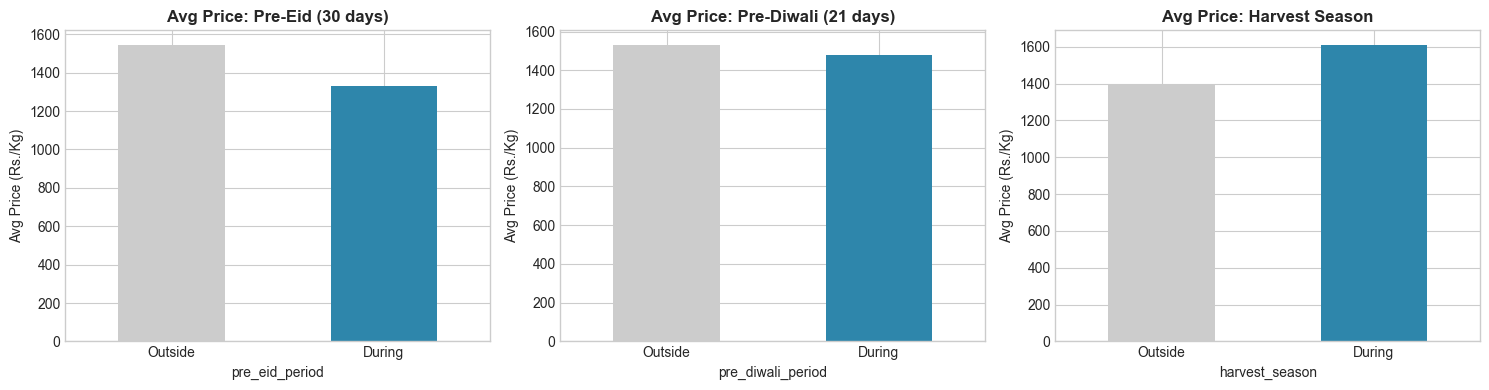

In [6]:
# Price by festival/demand period
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, col, title in zip(axes, 
    ['pre_eid_period', 'pre_diwali_period', 'harvest_season'],
    ['Pre-Eid (30 days)', 'Pre-Diwali (21 days)', 'Harvest Season']):
    merged.groupby(col)['AvgPrice'].mean().plot(kind='bar', ax=ax, color=['#ccc', '#2E86AB'])
    ax.set_title(f'Avg Price: {title}', fontweight='bold')
    ax.set_xticklabels(['Outside', 'During'], rotation=0)
    ax.set_ylabel('Avg Price (Rs./Kg)')

plt.tight_layout()
plt.show()

## 4. Feature Engineering

In [7]:
feat = merged.copy()
feat = feat.sort_values('Date').reset_index(drop=True)

# --- Price lag features ---
for lag in [1, 2, 3, 5, 7, 14, 21, 30]:
    feat[f'price_lag_{lag}'] = feat['AvgPrice'].shift(lag)

# --- Price rolling features ---
for window in [3, 7, 14, 30, 60]:
    feat[f'price_roll_mean_{window}'] = feat['AvgPrice'].shift(1).rolling(window).mean()
    feat[f'price_roll_std_{window}'] = feat['AvgPrice'].shift(1).rolling(window).std()

# --- Price momentum ---
feat['price_change_1'] = feat['AvgPrice'].shift(1) - feat['AvgPrice'].shift(2)
feat['price_change_7'] = feat['AvgPrice'].shift(1) - feat['AvgPrice'].shift(8)
feat['price_pct_change_1'] = feat['AvgPrice'].shift(1).pct_change()
feat['price_pct_change_7'] = feat['AvgPrice'].shift(1).pct_change(7)

# --- Volume features (lagged to avoid leakage) ---
feat['sold_lag1'] = feat['Total_Sold'].shift(1)
feat['arrived_lag1'] = feat['Total_Arrived'].shift(1)
feat['sold_to_arrived_ratio'] = feat['Total_Sold'].shift(1) / feat['Total_Arrived'].shift(1).clip(lower=1)
for window in [7, 14, 30]:
    feat[f'sold_roll_mean_{window}'] = feat['Total_Sold'].shift(1).rolling(window).mean()

# --- Weather features (lagged — weather affects supply with delay) ---
# Cumulative rainfall over past N days (affects current supply)
for window in [7, 14, 30, 60, 90]:
    feat[f'idukki_rain_{window}d'] = feat['rain_mm'].rolling(window).sum()
    feat[f'idukki_temp_max_{window}d'] = feat['temp_max_c'].rolling(window).mean()

# Guatemala rainfall (affects competing supply with ~2-3 month lag)
for window in [30, 60, 90]:
    feat[f'guatemala_rain_{window}d'] = feat['gt_rain_mm'].rolling(window).sum()

feat['humidity_avg_30d'] = feat['humidity_pct'].rolling(30).mean()

# --- Financial features (lagged 1 day) ---
feat['usdinr_lag1'] = feat['USDINR'].shift(1)
feat['usdinr_change_7d'] = feat['USDINR'].shift(1) - feat['USDINR'].shift(8)
feat['usdinr_roll_mean_30'] = feat['USDINR'].shift(1).rolling(30).mean()

feat['oil_lag1'] = feat['CrudeOil_USD'].shift(1)
feat['oil_change_7d'] = feat['CrudeOil_USD'].shift(1) - feat['CrudeOil_USD'].shift(8)

feat['gold_lag1'] = feat['Gold_USD'].shift(1)
feat['gold_change_30d'] = feat['Gold_USD'].shift(1) - feat['Gold_USD'].shift(31)

feat['nifty_lag1'] = feat['Nifty50'].shift(1)
feat['nifty_change_7d'] = feat['Nifty50'].shift(1) - feat['Nifty50'].shift(8)

# --- Calendar features ---
feat['month'] = feat['Date'].dt.month
feat['day_of_week'] = feat['Date'].dt.dayofweek
feat['quarter'] = feat['Date'].dt.quarter
feat['week_of_year'] = feat['Date'].dt.isocalendar().week.astype(int)
feat['month_sin'] = np.sin(2 * np.pi * feat['month'] / 12)
feat['month_cos'] = np.cos(2 * np.pi * feat['month'] / 12)
feat['days_gap'] = feat['Date'].diff().dt.days

# Drop rows with NaN
feat = feat.dropna().reset_index(drop=True)
print(f'Feature dataset: {feat.shape[0]} rows, {feat.shape[1]} columns')

Feature dataset: 2939 rows, 86 columns


## 5. Model Training — Baseline vs Enriched

In [8]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Define feature groups
# Current-day columns that would cause leakage
leakage_cols = ['Date', 'AvgPrice', 'Total_Lots', 'Total_Arrived', 'Total_Sold', 'MaxPrice', 'Num_Auctions',
                'rain_mm', 'precipitation_mm', 'temp_max_c', 'temp_min_c', 'humidity_pct',
                'gt_precipitation_mm', 'gt_rain_mm', 'gt_temp_max_c', 'gt_temp_min_c',
                'USDINR', 'CrudeOil_USD', 'Gold_USD', 'Nifty50']

all_feature_cols = [c for c in feat.columns if c not in leakage_cols]

# Baseline features: only price lags + rolling + calendar (same as original notebook)
baseline_cols = [c for c in all_feature_cols if any(c.startswith(p) for p in 
    ['price_lag', 'price_roll', 'price_change', 'price_pct', 'month', 'day_of_week', 
     'quarter', 'week_of_year', 'month_sin', 'month_cos', 'days_gap',
     'sold_to_arrived', 'sold_roll', 'sold_lag', 'arrived_lag'])]

# Enriched features: everything
enriched_cols = all_feature_cols

print(f'Baseline features: {len(baseline_cols)}')
print(f'Enriched features: {len(enriched_cols)}')
print(f'\nNew external features ({len(enriched_cols) - len(baseline_cols)}):')
new_cols = [c for c in enriched_cols if c not in baseline_cols]
print(new_cols)

Baseline features: 35
Enriched features: 66

New external features (31):
['wedding_season', 'harvest_season', 'peak_harvest', 'pre_eid_period', 'pre_diwali_period', 'pre_onam_period', 'xmas_newyear', 'ENSO_ONI', 'idukki_rain_7d', 'idukki_temp_max_7d', 'idukki_rain_14d', 'idukki_temp_max_14d', 'idukki_rain_30d', 'idukki_temp_max_30d', 'idukki_rain_60d', 'idukki_temp_max_60d', 'idukki_rain_90d', 'idukki_temp_max_90d', 'guatemala_rain_30d', 'guatemala_rain_60d', 'guatemala_rain_90d', 'humidity_avg_30d', 'usdinr_lag1', 'usdinr_change_7d', 'usdinr_roll_mean_30', 'oil_lag1', 'oil_change_7d', 'gold_lag1', 'gold_change_30d', 'nifty_lag1', 'nifty_change_7d']


In [9]:
# Temporal split
y = feat['AvgPrice']
dates = feat['Date']
split_idx = int(len(feat) * 0.8)

dates_train, dates_test = dates.iloc[:split_idx], dates.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f'Train: {split_idx} samples ({dates_train.iloc[0].date()} to {dates_train.iloc[-1].date()})')
print(f'Test:  {len(feat) - split_idx} samples ({dates_test.iloc[0].date()} to {dates_test.iloc[-1].date()})')

# Train both baseline and enriched models
all_results = {}
all_predictions = {}

for feature_set_name, feature_set in [('Baseline', baseline_cols), ('Enriched', enriched_cols)]:
    X = feat[feature_set]
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    
    models = {
        'Ridge': Ridge(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_leaf=5, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=300, max_depth=6, learning_rate=0.05,
                                                       subsample=0.8, random_state=42)
    }
    
    print(f'\n=== {feature_set_name} ({len(feature_set)} features) ===')
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        key = f'{feature_set_name} - {name}'
        all_predictions[key] = y_pred
        
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        r2 = r2_score(y_test, y_pred)
        
        all_results[key] = {'Features': feature_set_name, 'Model': name,
                            'MAE': mae, 'RMSE': rmse, 'MAPE': f'{mape:.2f}%', 'R²': r2}
        print(f'  {name:20s} | MAE: {mae:8.2f} | RMSE: {rmse:8.2f} | MAPE: {mape:5.2f}% | R²: {r2:.4f}')
        
        # Store trained model for later use
        if feature_set_name == 'Enriched':
            models[name] = model  # keep the fitted model

results_df = pd.DataFrame(all_results).T
results_df

Train: 2351 samples (2015-08-12 to 2024-02-16)
Test:  588 samples (2024-02-17 to 2026-02-06)

=== Baseline (35 features) ===
  Ridge                | MAE:    40.96 | RMSE:    53.76 | MAPE:  1.77% | R²: 0.9798


  Random Forest        | MAE:    49.31 | RMSE:    63.76 | MAPE:  2.12% | R²: 0.9716


  Gradient Boosting    | MAE:    65.08 | RMSE:    80.80 | MAPE:  2.76% | R²: 0.9544

=== Enriched (66 features) ===
  Ridge                | MAE:    50.48 | RMSE:    63.51 | MAPE:  2.15% | R²: 0.9718


  Random Forest        | MAE:   119.96 | RMSE:   142.25 | MAPE:  4.97% | R²: 0.8587


  Gradient Boosting    | MAE:   166.85 | RMSE:   200.63 | MAPE:  6.93% | R²: 0.7190


,Features,Model,MAE,RMSE,MAPE,R²
Baseline - Ridge,Baseline,Ridge,40.955836,53.759921,1.77%,0.979823
Baseline - Random Forest,Baseline,Random Forest,49.306394,63.756031,2.12%,0.971622
Baseline - Gradient Boosting,Baseline,Gradient Boosting,65.077505,80.802769,2.76%,0.954418
Enriched - Ridge,Enriched,Ridge,50.481232,63.506878,2.15%,0.971843
Enriched - Random Forest,Enriched,Random Forest,119.95783,142.246443,4.97%,0.858739
Enriched - Gradient Boosting,Enriched,Gradient Boosting,166.847938,200.633464,6.93%,0.718975


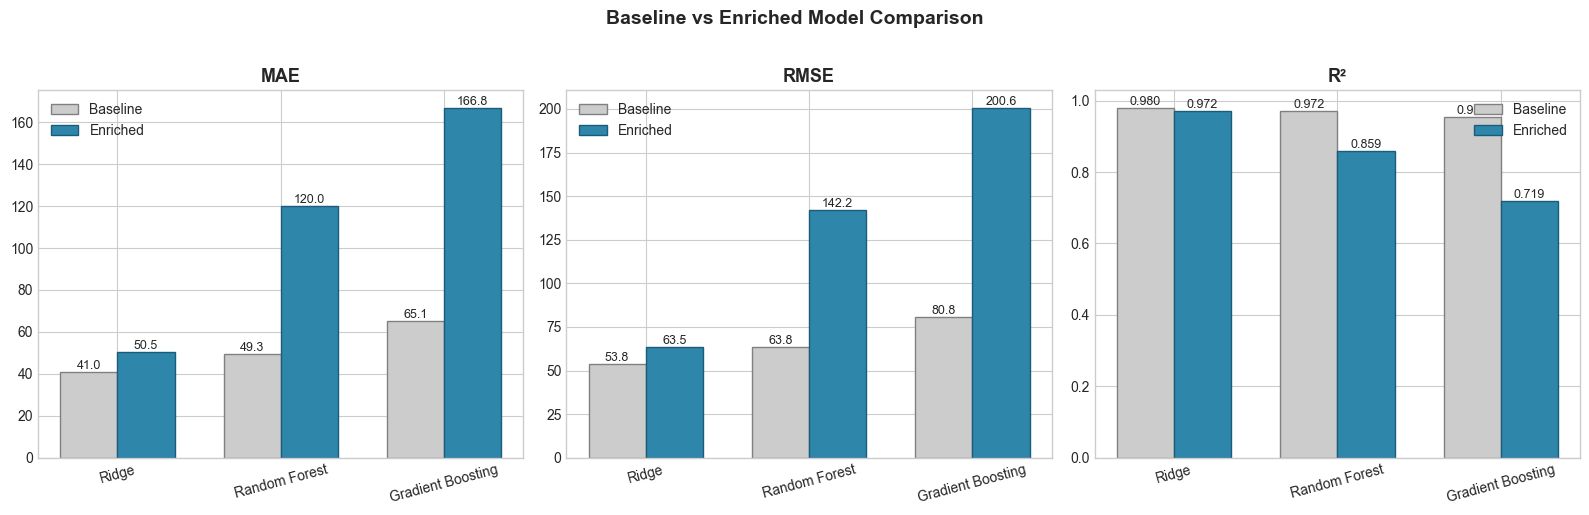

In [10]:
# Side-by-side comparison: Baseline vs Enriched
comparison = results_df[['Features', 'Model', 'MAE', 'RMSE', 'R²']].copy()
comparison['MAE'] = comparison['MAE'].astype(float).round(2)
comparison['RMSE'] = comparison['RMSE'].astype(float).round(2)
comparison['R²'] = comparison['R²'].astype(float).round(4)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, metric in zip(axes, ['MAE', 'RMSE', 'R²']):
    baseline_vals = comparison[comparison['Features'] == 'Baseline'][metric].values
    enriched_vals = comparison[comparison['Features'] == 'Enriched'][metric].values
    model_names = comparison[comparison['Features'] == 'Baseline']['Model'].values
    
    x = np.arange(len(model_names))
    width = 0.35
    ax.bar(x - width/2, baseline_vals, width, label='Baseline', color='#cccccc', edgecolor='gray')
    ax.bar(x + width/2, enriched_vals, width, label='Enriched', color='#2E86AB', edgecolor='#1a5c7a')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=15)
    ax.set_title(metric, fontsize=13, fontweight='bold')
    ax.legend()
    
    # Add value labels
    for i, (b, e) in enumerate(zip(baseline_vals, enriched_vals)):
        ax.text(i - width/2, b, f'{b:.1f}' if metric != 'R²' else f'{b:.3f}', ha='center', va='bottom', fontsize=9)
        ax.text(i + width/2, e, f'{e:.1f}' if metric != 'R²' else f'{e:.3f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Baseline vs Enriched Model Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 6. Best Model Analysis

Best enriched model: Enriched - Ridge
  MAE:  50.48
  MAPE: 2.15%
  R²:   0.9718


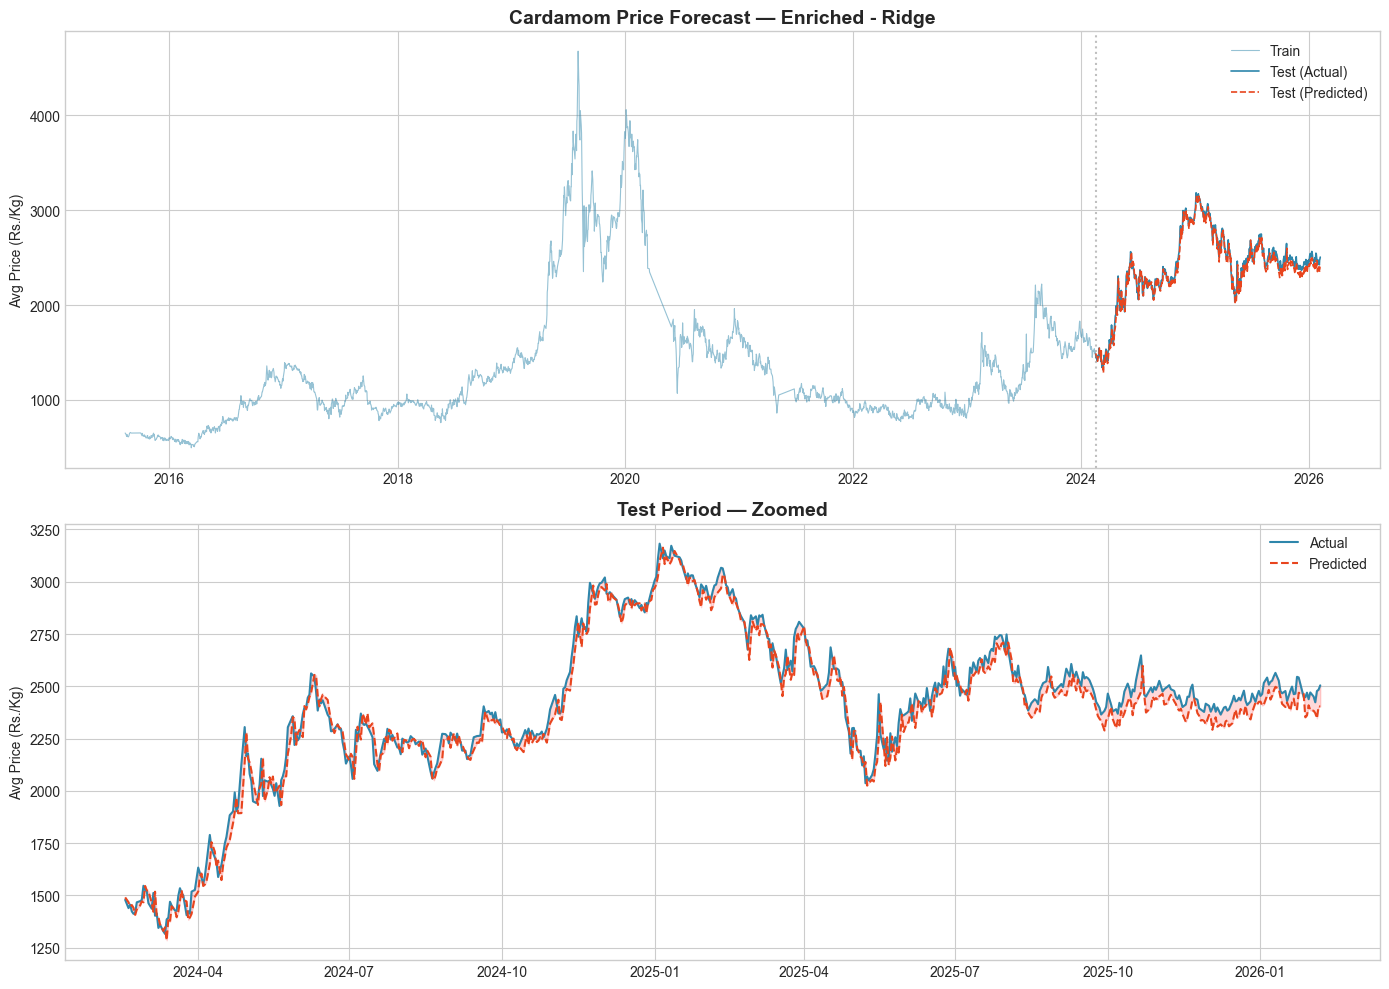

In [11]:
# Identify best enriched model
enriched_results = {k: v for k, v in all_results.items() if v['Features'] == 'Enriched'}
best_key = min(enriched_results, key=lambda k: enriched_results[k]['MAE'])
best_pred = all_predictions[best_key]
print(f'Best enriched model: {best_key}')
print(f'  MAE:  {all_results[best_key]["MAE"]:.2f}')
print(f'  MAPE: {all_results[best_key]["MAPE"]}')
print(f'  R²:   {all_results[best_key]["R²"]:.4f}')

# Plot actual vs predicted
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

axes[0].plot(dates_train, y_train, label='Train', color='#2E86AB', linewidth=0.8, alpha=0.5)
axes[0].plot(dates_test, y_test, label='Test (Actual)', color='#2E86AB', linewidth=1.2)
axes[0].plot(dates_test, best_pred, label=f'Test (Predicted)', color='#E8451E', linewidth=1.2, linestyle='--')
axes[0].set_title(f'Cardamom Price Forecast — {best_key}', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Avg Price (Rs./Kg)')
axes[0].legend()
axes[0].axvline(dates_test.iloc[0], color='gray', linestyle=':', alpha=0.5)

axes[1].plot(dates_test, y_test, label='Actual', color='#2E86AB', linewidth=1.5)
axes[1].plot(dates_test, best_pred, label='Predicted', color='#E8451E', linewidth=1.5, linestyle='--')
axes[1].fill_between(dates_test, y_test, best_pred, alpha=0.15, color='red')
axes[1].set_title('Test Period — Zoomed', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Avg Price (Rs./Kg)')
axes[1].legend()

plt.tight_layout()
plt.show()

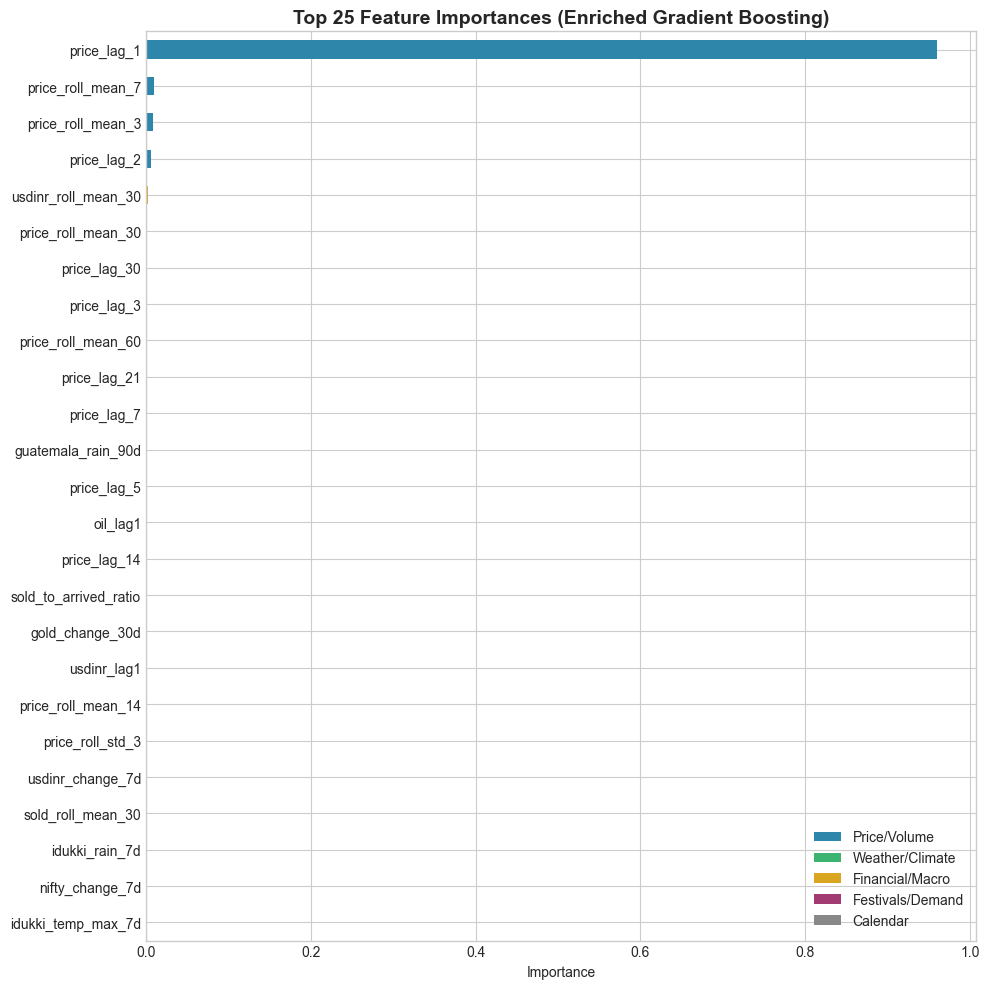

In [12]:
# Feature importance — enriched Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=300, max_depth=6, learning_rate=0.05,
                                     subsample=0.8, random_state=42)
gb_model.fit(feat[enriched_cols].iloc[:split_idx], y_train)
importances = gb_model.feature_importances_

feat_imp = pd.Series(importances, index=enriched_cols).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 10))
# Color code by category
colors = []
for f in feat_imp.tail(25).index:
    if 'price' in f or 'sold' in f or 'arrived' in f:
        colors.append('#2E86AB')  # blue = price/volume
    elif 'rain' in f or 'temp' in f or 'humid' in f or 'ENSO' in f or 'guatemala' in f or 'idukki' in f:
        colors.append('#3CB371')  # green = weather
    elif 'usdinr' in f or 'oil' in f or 'gold' in f or 'nifty' in f:
        colors.append('#DAA520')  # gold = financial
    elif any(x in f for x in ['wedding', 'harvest', 'eid', 'diwali', 'onam', 'xmas']):
        colors.append('#A23B72')  # purple = festivals
    else:
        colors.append('#888888')  # gray = calendar

feat_imp.tail(25).plot(kind='barh', ax=ax, color=colors)
ax.set_title('Top 25 Feature Importances (Enriched Gradient Boosting)', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance')

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2E86AB', label='Price/Volume'),
                   Patch(facecolor='#3CB371', label='Weather/Climate'),
                   Patch(facecolor='#DAA520', label='Financial/Macro'),
                   Patch(facecolor='#A23B72', label='Festivals/Demand'),
                   Patch(facecolor='#888888', label='Calendar')]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

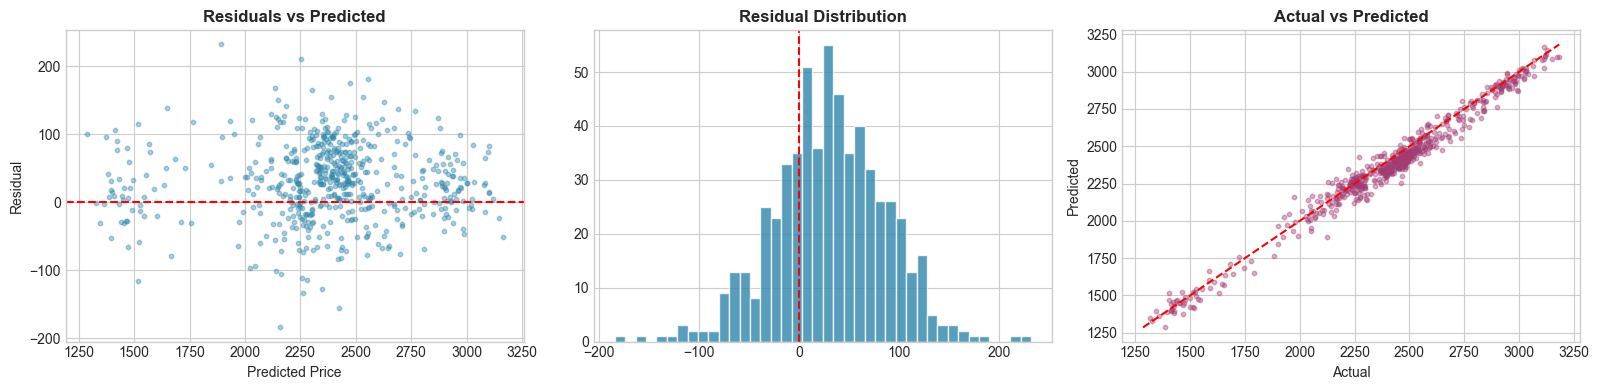

In [13]:
# Residual analysis
residuals = y_test.values - best_pred

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].scatter(best_pred, residuals, alpha=0.4, s=10, color='#2E86AB')
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Residuals vs Predicted', fontweight='bold')
axes[0].set_xlabel('Predicted Price')
axes[0].set_ylabel('Residual')

axes[1].hist(residuals, bins=40, color='#2E86AB', edgecolor='white', alpha=0.8)
axes[1].axvline(0, color='red', linestyle='--')
axes[1].set_title('Residual Distribution', fontweight='bold')

axes[2].scatter(y_test, best_pred, alpha=0.4, s=10, color='#A23B72')
min_val, max_val = min(y_test.min(), best_pred.min()), max(y_test.max(), best_pred.max())
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--')
axes[2].set_title('Actual vs Predicted', fontweight='bold')
axes[2].set_xlabel('Actual')
axes[2].set_ylabel('Predicted')

plt.tight_layout()
plt.show()

## 7. 30-Day Forecast

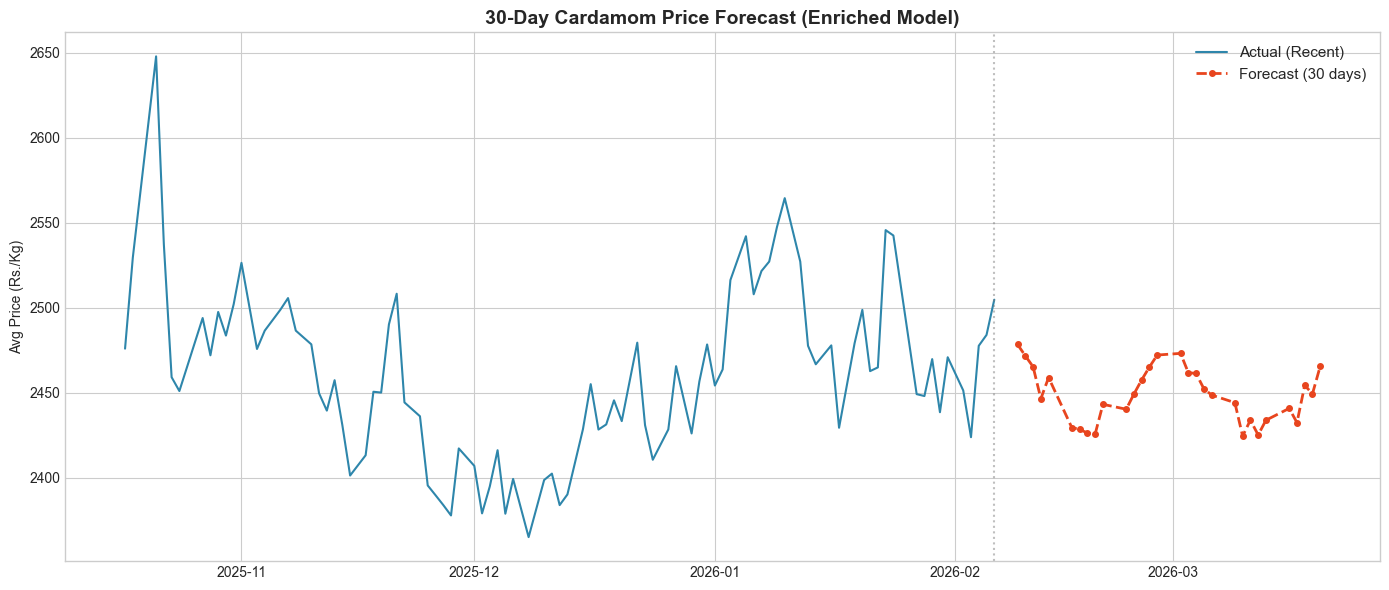


Forecasted Prices:
      Date  AvgPrice_Forecast
2026-02-09        2478.316101
2026-02-10        2471.610084
2026-02-11        2465.209206
2026-02-12        2446.406697
2026-02-13        2458.822198
2026-02-16        2429.293678
2026-02-17        2428.389848
2026-02-18        2426.121739
2026-02-19        2425.646758
2026-02-20        2443.078727
2026-02-23        2440.182356
2026-02-24        2449.169290
2026-02-25        2457.503077
2026-02-26        2465.124306
2026-02-27        2472.072163
2026-03-02        2473.062164
2026-03-03        2461.719750
2026-03-04        2461.222770
2026-03-05        2452.299164
2026-03-06        2448.547488
2026-03-09        2444.052690
2026-03-10        2424.361875
2026-03-11        2433.788076
2026-03-12        2425.045838
2026-03-13        2433.698259
2026-03-16        2440.691304
2026-03-17        2432.303289
2026-03-18        2454.207176
2026-03-19        2449.290775
2026-03-20        2465.534136


In [14]:
def forecast_enriched(model, feat_df, feature_cols, n_steps=30):
    """Multi-step forecast using enriched features."""
    history = feat_df.copy()
    forecasts = []
    last_date = history['Date'].iloc[-1]
    
    for step in range(n_steps):
        last_row = history.iloc[-1:][feature_cols]
        pred = model.predict(last_row)[0]
        
        next_date = last_date + timedelta(days=1)
        while next_date.weekday() >= 5:
            next_date += timedelta(days=1)
        
        forecasts.append({'Date': next_date, 'AvgPrice_Forecast': pred})
        
        # Build new row
        new_row = history.iloc[-1:].copy()
        new_row['Date'] = next_date
        new_row['AvgPrice'] = pred
        
        # Update price lags
        price_history = list(history['AvgPrice'].values) + [pred]
        for lag in [1, 2, 3, 5, 7, 14, 21, 30]:
            col = f'price_lag_{lag}'
            if col in new_row.columns and lag < len(price_history):
                new_row[col] = price_history[-lag-1]
        
        # Update calendar
        new_row['month'] = next_date.month
        new_row['day_of_week'] = next_date.weekday()
        new_row['quarter'] = (next_date.month - 1) // 3 + 1
        new_row['week_of_year'] = next_date.isocalendar()[1]
        new_row['month_sin'] = np.sin(2 * np.pi * next_date.month / 12)
        new_row['month_cos'] = np.cos(2 * np.pi * next_date.month / 12)
        new_row['days_gap'] = (next_date - last_date).days
        
        history = pd.concat([history, new_row], ignore_index=True)
        last_date = next_date
    
    return pd.DataFrame(forecasts)

# Re-train best model on ALL data for final forecast
best_model_name = all_results[best_key]['Model']
if best_model_name == 'Ridge':
    final_model = Ridge(alpha=1.0)
elif best_model_name == 'Random Forest':
    final_model = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_leaf=5, random_state=42, n_jobs=-1)
else:
    final_model = GradientBoostingRegressor(n_estimators=300, max_depth=6, learning_rate=0.05, subsample=0.8, random_state=42)

final_model.fit(feat[enriched_cols], feat['AvgPrice'])
forecast_df = forecast_enriched(final_model, feat, enriched_cols, n_steps=30)

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
recent = feat.tail(90)
ax.plot(recent['Date'], recent['AvgPrice'], label='Actual (Recent)', color='#2E86AB', linewidth=1.5)
ax.plot(forecast_df['Date'], forecast_df['AvgPrice_Forecast'], label='Forecast (30 days)',
        color='#E8451E', linewidth=2, linestyle='--', marker='o', markersize=4)
ax.axvline(recent['Date'].iloc[-1], color='gray', linestyle=':', alpha=0.5)
ax.set_title('30-Day Cardamom Price Forecast (Enriched Model)', fontsize=14, fontweight='bold')
ax.set_ylabel('Avg Price (Rs./Kg)')
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

print('\nForecasted Prices:')
forecast_df['Date'] = forecast_df['Date'].dt.strftime('%Y-%m-%d')
print(forecast_df.to_string(index=False))

## 8. Summary

### External Data Integrated
- **Weather:** Idukki rainfall/temp/humidity + Guatemala rainfall/temp (daily, Open-Meteo)
- **Climate:** ENSO/El Niño index (NOAA)
- **Financial:** USD/INR, Brent Crude Oil, Gold, Nifty 50 (Yahoo Finance)
- **Demand:** Festival calendar (Eid, Diwali, Onam, wedding/harvest seasons)

### Key Insights
- Feature importance shows which external signals actually matter for price prediction
- The Baseline vs Enriched comparison quantifies the value of external data
- Weather features capture supply-side shocks, while financial features capture macro trends

### Further Improvements
- Add Guatemala/global cardamom export volumes (UN Comtrade — monthly, needs API key)
- Add Google Trends for "cardamom" as a demand proxy (rate-limited, needs workaround)
- Try LSTM/Transformer models for longer-horizon forecasting
- Implement time-series cross-validation for robust hyperparameter tuning
- Add confidence intervals to forecasts